# Generate a PDF describing occurence frequency in trait space

In [1]:
%load_ext autoreload
%autoreload 2

In [41]:
import os

import constants
import matplotlib.pyplot as plt
import metabolic as mi
import numpy as np
import util
import xarray as xr

In [3]:
df = mi.open_traits_df()
df

,Species,Phylum,alphaD_log10,Emet,Eo,Ao,Ac,Phi_crit
0,Acanthephyra acutifrons,Crustacea,0.479565,0.040200,-0.027836,0.264715,0.131959,2.006040
1,Acanthephyra curtirostris,Crustacea,0.377714,0.043938,0.038027,0.252578,0.141861,1.780456
2,Acanthephyra purpurea,Crustacea,1.035748,0.840722,0.131972,0.230068,0.073638,3.124330
3,Acanthephyra smithi,Crustacea,1.082577,0.313173,-0.030067,0.286307,0.174423,1.641453
4,Acipenser brevirostrum,Chordata,NaN,NaN,0.362569,0.218524,0.048415,4.513525
...,...,...,...,...,...,...,...,...
56,Styela plicata,Tunicata,0.433791,0.346635,-0.190998,0.061336,0.043505,1.409863
57,Systellaspis debilis,Crustacea,0.779626,0.418652,0.226970,0.219289,0.096003,2.284196
58,Tarletonbeania crenularis,Chordata,NaN,NaN,0.213307,0.203696,0.051780,3.933876
59,Tautogolabrus adspersus,Chordata,0.801974,0.327012,0.244520,0.170886,0.051204,3.337395


<xarray.DataArray 'Ac' (Ac: 8)>
array([0.0258, 0.0399, 0.0619, 0.0959, 0.1486, 0.2303, 0.3568, 0.5528])
Dimensions without coordinates: Ac
Attributes:
    long_name:  Hypoxic tolerance (normalized by critical MI)
    units:      1/kPa

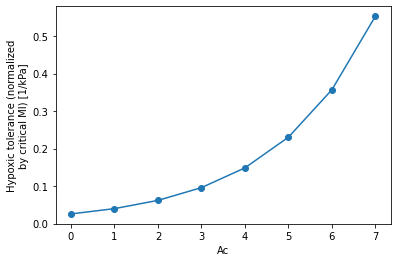

In [18]:
log10_values = np.log10(df.Ac.values)
Ac_coord_data = np.round(np.logspace(log10_values.min(), log10_values.max(), 8, base=10), 4)
Ac_coord = xr.DataArray(Ac_coord_data, dims=('Ac'), name='Ac')
Ac_coord.attrs = df.Ac.attrs
Ac_coord.plot(marker='o')
Ac_coord

<xarray.DataArray 'Ao' (Ao: 8)>
array([0.0613, 0.0962, 0.1508, 0.2364, 0.3707, 0.5813, 0.9114, 1.4291])
Dimensions without coordinates: Ao
Attributes:
    long_name:  Hypoxic tolerance
    units:      1/kPa

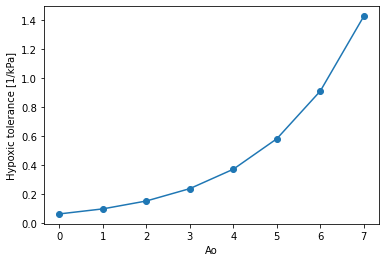

In [17]:
log10_values = np.log10(df.Ao.values)
Ao_coord_data = np.round(np.logspace(log10_values.min(), log10_values.max(), 8, base=10), 4)
Ao_coord = xr.DataArray(Ao_coord_data, dims=('Ao'), name='Ao')
Ao_coord.attrs = df.Ao.attrs
Ao_coord.plot(marker='o')
Ao_coord

<xarray.DataArray 'Eo' (Eo: 7)>
array([-0.2, -0. ,  0.2,  0.4,  0.6,  0.8,  1. ])
Dimensions without coordinates: Eo
Attributes:
    long_name:  Temperature sensitivity of MI
    units:      eV

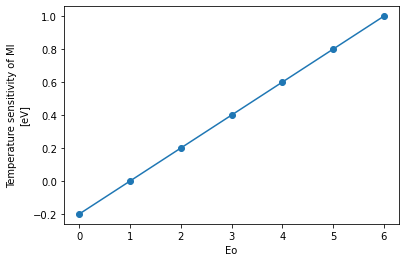

In [19]:
Eo_coord = xr.DataArray(np.round(np.linspace(-0.2, 1.0, 7), 4), dims=('Eo'), name=('Eo'))
Eo_coord.attrs = df.Eo.attrs
Eo_coord.plot(marker='o')
Eo_coord

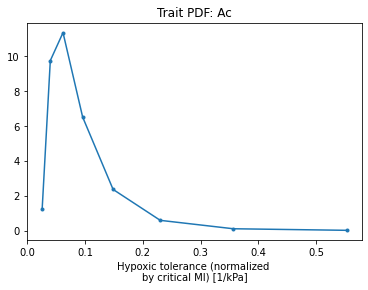

In [20]:
obj_Ac_pdf = mi.trait_pdf(df, 'Ac')
plt.plot(Ac_coord, obj_Ac_pdf.fitted(Ac_coord), '.-')
plt.title('Trait PDF: Ac')
plt.xlabel(util.attrs_label(df.Ac.attrs));

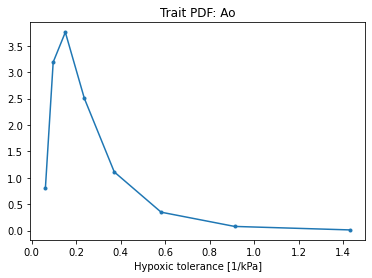

In [21]:
obj_Ao_pdf = mi.trait_pdf(df, 'Ao')
plt.plot(Ao_coord, obj_Ao_pdf.fitted(Ao_coord), '.-')
plt.title('Trait PDF: Ao')
plt.xlabel(util.attrs_label(df.Ao.attrs));

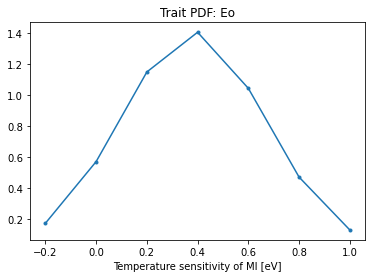

In [22]:
obj_Eo_pdf = mi.trait_pdf(df, 'Eo')
plt.plot(Eo_coord, obj_Eo_pdf.fitted(Eo_coord), '.-')
plt.title('Trait PDF: Eo')
plt.xlabel(util.attrs_label(df.Eo.attrs));

In [44]:
dso = xr.Dataset()

# active metabolism
dso['trait_spc_active'] = xr.DataArray(
    obj_Ac_pdf.fitted(Ac_coord), dims=('Ac'), coords={'Ac': Ac_coord}
) * xr.DataArray(obj_Eo_pdf.fitted(Eo_coord), dims=('Eo'), coords={'Eo': Eo_coord})
dso['trait_spc_active'] = dso.trait_spc_active / dso.trait_spc_active.sum()
np.testing.assert_almost_equal(dso.trait_spc_active.sum(), 1.0)

dso.trait_spc_active.attrs['long_name'] = 'Trait density (active)'
dso.trait_spc_active.attrs['units'] = ' '.join([Eo_coord.units, Ac_coord.units])
dso.trait_spc_active.attrs['metabolic_baseline'] = 'active'
dso.trait_spc_active.attrs['N_traits'] = dso.trait_spc_active.size


# resting metabolism
dso['trait_spc_resting'] = xr.DataArray(
    obj_Ao_pdf.fitted(Ao_coord), dims=('Ao'), coords={'Ao': Ao_coord}
) * xr.DataArray(obj_Eo_pdf.fitted(Eo_coord), dims=('Eo'), coords={'Eo': Eo_coord})
dso['trait_spc_resting'] = dso.trait_spc_resting / dso.trait_spc_resting.sum()
np.testing.assert_almost_equal(dso.trait_spc_resting.sum(), 1.0)

dso.trait_spc_resting.attrs['long_name'] = 'Trait density (resting)'
dso.trait_spc_resting.attrs['units'] = ' '.join([Eo_coord.units, Ao_coord.units])
dso.trait_spc_resting.attrs['metabolic_baseline'] = 'resting'
dso.trait_spc_resting.attrs['N_traits'] = dso.trait_spc_resting.size

dso

<xarray.Dataset>
Dimensions:            (Ac: 8, Eo: 7, Ao: 8)
Coordinates:
  * Ac                 (Ac) float64 0.0258 0.0399 0.0619 ... 0.3568 0.5528
  * Eo                 (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * Ao                 (Ao) float64 0.0613 0.0962 0.1508 ... 0.5813 0.9114 1.429
Data variables:
    trait_spc_active   (Ac, Eo) float64 0.001347 0.004475 ... 1.041e-05
    trait_spc_resting  (Ao, Eo) float64 0.002386 0.007927 ... 0.000106 2.896e-05

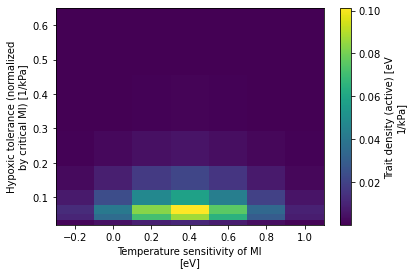

In [33]:
dso.trait_spc_active.plot();

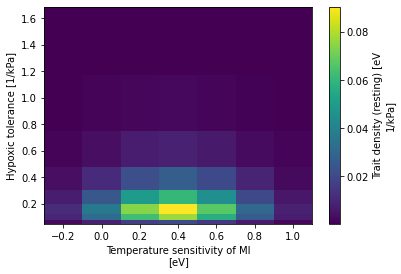

In [34]:
dso.trait_spc_resting.plot();

## Use root finding technique to solve to ATmax

Loop over traits and values of $P_{\mathrm{O}_2}$ to find ATmax

First illustrate computation on a subset of traits.

In [39]:
mi.dEodT_bar

0.022

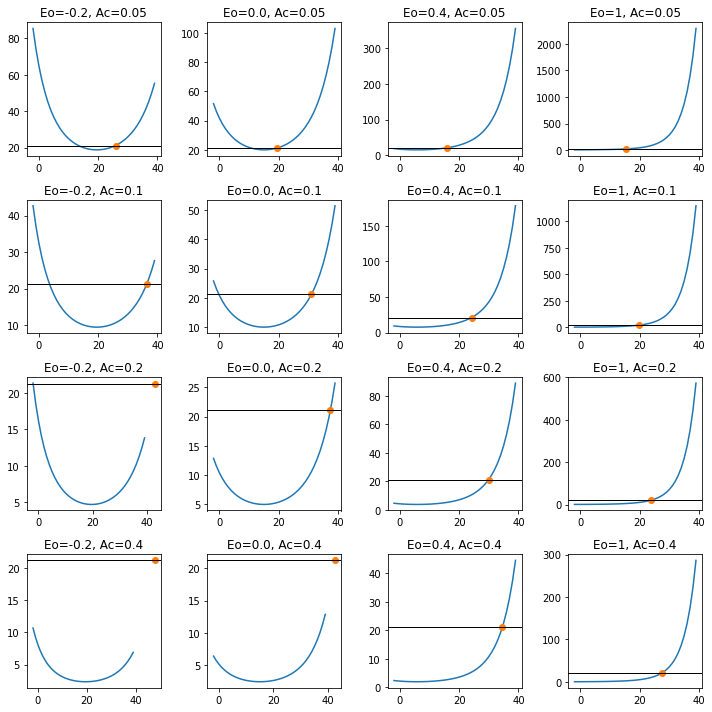

In [45]:
fig, axs = plt.subplots(4, 4, figsize=(10, 10))

PO2_atm = constants.XiO2 * constants.kPa_per_atm

T = np.arange(-2.0, 40.0, 1.0)

for i, Ac in enumerate([0.05, 0.1, 0.2, 0.4]):
    for j, Eo in enumerate([-0.2, 0.0, 0.4, 1]):
        ax = axs[i, j]
        ATmax_ij = mi.compute_ATmax(PO2_atm, Ac, Eo, dEodT=mi.dEodT_bar)
        ax.plot(T, mi.pO2_at_Phi_one(T, Ac, Eo, dEodT=mi.dEodT_bar), '-')
        ax.plot(ATmax_ij, PO2_atm, 'o')
        ax.axhline(PO2_atm, linewidth=1, color='k')
        ax.set_title(f'Eo={Eo}, Ac={Ac}')

fig.tight_layout()

Now compute ATmax over entire trait-space domain.

In [59]:
PO2_atm = constants.XiO2 * constants.kPa_per_atm

for v in ['trait_spc_active', 'trait_spc_resting']:
    trait_space = dso[v]
    metabolic_baseline = trait_space.attrs['metabolic_baseline']
    hypoxic_tol, temp_sens = trait_space.dims

    ATmax = xr.full_like(trait_space, fill_value=0.0)
    name = f'ATmax_{metabolic_baseline}'
    ATmax.attrs['long_name'] = 'AT$_{max}$' + f' ({metabolic_baseline})'
    ATmax.attrs['units'] = '°C'
    ATmax.attrs['note'] = f'computed using dEodT = {mi.dEodT_bar}'

    for i, A_parm in enumerate(trait_space[hypoxic_tol].values):
        for j, Eo in enumerate(trait_space[temp_sens].values):
            ATmax_ij = mi.compute_ATmax(PO2_atm, Ac=A_parm, Eo=Eo, dEodT=mi.dEodT_bar)
            ATmax[i, j] = ATmax_ij

    dso[name] = ATmax

dso

<xarray.Dataset>
Dimensions:            (Ac: 8, Eo: 7, Ao: 8)
Coordinates:
  * Ac                 (Ac) float64 0.0258 0.0399 0.0619 ... 0.3568 0.5528
  * Eo                 (Eo) float64 -0.2 -0.0 0.2 0.4 0.6 0.8 1.0
  * Ao                 (Ao) float64 0.0613 0.0962 0.1508 ... 0.5813 0.9114 1.429
Data variables:
    trait_spc_active   (Ac, Eo) float64 0.001347 0.004475 ... 1.041e-05
    trait_spc_resting  (Ao, Eo) float64 0.002386 0.007927 ... 0.000106 2.896e-05
    ATmax_active       (Ac, Eo) float64 nan nan nan nan ... 33.55 31.08 29.07
    ATmax_resting      (Ao, Eo) float64 30.02 24.35 20.8 ... 38.56 35.77 33.43

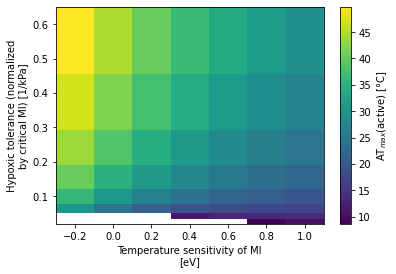

In [54]:
dso.ATmax_active.plot();

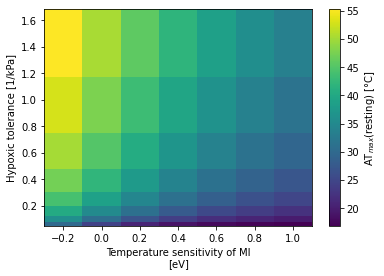

In [51]:
dso.ATmax_resting.plot();

In [58]:
clobber = True

this_notebook = 'trait-space-joint-pdf.ipynb'

curator = util.curator_local_assets()

if clobber:
    cache_file = 'data/cache/idealized-trait-space.zarr'
    os.makedirs(os.path.dirname(cache_file), exist_ok=True)
    dso.to_zarr(cache_file, mode='w', consolidated=True)

    curator.add_source(
        key='trait-space',
        urlpath=cache_file,
        description=f'Idealized trait space generated by {this_notebook}',
        driver='zarr',
        overwrite=True,
    )

cat = curator.open_catalog()
ds_cache = cat['trait-space'].to_dask()
xr.testing.assert_identical(dso, ds_cache)

dso.info()

overwriting "trait-space" key in "sources"
xarray.Dataset {
dimensions:
	Ac = 8 ;
	Eo = 7 ;
	Ao = 8 ;

variables:
	float64 Ac(Ac) ;
		Ac:long_name = Hypoxic tolerance (normalized by critical MI) ;
		Ac:units = 1/kPa ;
	float64 Eo(Eo) ;
		Eo:long_name = Temperature sensitivity of MI ;
		Eo:units = eV ;
	float64 trait_spc_active(Ac, Eo) ;
		trait_spc_active:long_name = Trait density (active) ;
		trait_spc_active:units = eV 1/kPa ;
		trait_spc_active:metabolic_baseline = active ;
		trait_spc_active:N_traits = 56 ;
	float64 Ao(Ao) ;
		Ao:long_name = Hypoxic tolerance ;
		Ao:units = 1/kPa ;
	float64 trait_spc_resting(Ao, Eo) ;
		trait_spc_resting:long_name = Trait density (resting) ;
		trait_spc_resting:units = eV 1/kPa ;
		trait_spc_resting:metabolic_baseline = resting ;
		trait_spc_resting:N_traits = 56 ;
	float64 ATmax_active(Ac, Eo) ;
		ATmax_active:long_name = AT$_{max}$(active) ;
		ATmax_active:units = °C ;
		ATmax_active:metabolic_baseline = active ;
		ATmax_active:N_traits = 56 ;
		